# Superconductivity

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [2]:
sis_df = pd.read_csv(r"C:\Users\volca\Coding Projects\PHY 451\phy_451_super_data\SIS_11-13_data_4.323K_filter.csv")
sis_df.columns = [x.rstrip(' - Plot 0') for x in sis_df.columns]
#min_idx = np.argmax(sis_df['Current (mA)'])
#min_idx
#sis_df.to_numpy()[:] = np.roll(sis_df.to_numpy()[:], min_idx, axis = 0)
sis_df.head()

,Current (mA),Voltage (mV)
0,0.0,0.000044
1,0.0,0.000044
2,-0.1,0.000045
3,-0.2,0.000045
4,-0.3,0.000046


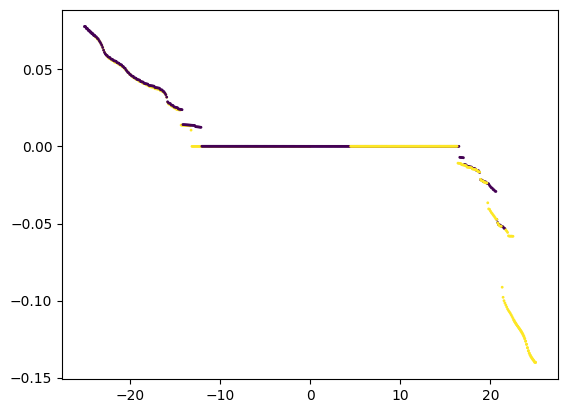

In [3]:
idxs = np.arange(len(sis_df))
mask = np.where(np.logical_and(np.quantile(idxs, 0.25) <= idxs, idxs <= np.quantile(idxs, 0.75)), 0, 1)
plt.scatter(sis_df['Current (mA)'], sis_df['Voltage (mV)'],
        c = mask, s = 1)

In [8]:
def clipped_line(x, m_0, m_1, curr_offset, epsilon, beta=5):
    H = lambda t: 1.0 / (1.0 + np.exp(-beta * t))

    R = H(x - curr_offset)# right side switch
    L = H(-x - curr_offset)# left side switch

    # right linear branch: m0*x + epsilon
    right_branch = (m_0 * x + epsilon) * R

    # left linear branch: m1*x + epsilon
    left_branch  = (m_1 * x + epsilon) * L

    # central flat region: epsilon * (1 - R - L)
    center = (epsilon + epsilon)/2 * (1 - R - L)

    return right_branch + left_branch + center
p0 = -1.5e-3, 1.5e-3, 15, -0.05,
param, pcov = scipy.optimize.curve_fit(clipped_line, sis_df['Current (mA)'], sis_df['Voltage (mV)'], p0 = p0)
param

array([-4.59600808e-03, -2.62182372e-03,  1.99855856e+01,  4.89301157e-03])

In [5]:
currents = np.linspace(sis_df['Current (mA)'].min(),sis_df['Current (mA)'].max(), 1000)
voltages = clipped_line(currents, *param)

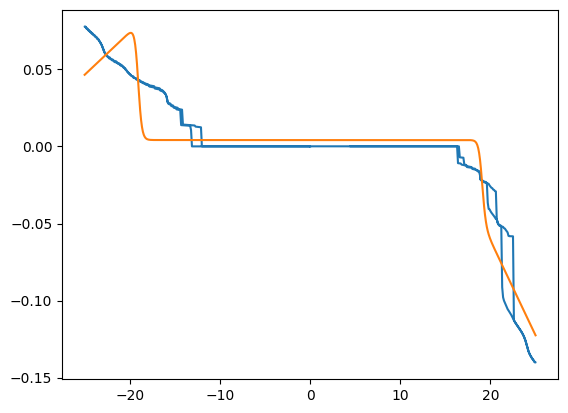

In [6]:
idxs = np.arange(len(sis_df))
mask = np.where(np.logical_and(np.quantile(idxs, 0.25) <= idxs, idxs <= np.quantile(idxs, 0.75)), 0, 1)
plt.plot(sis_df['Current (mA)'], sis_df['Voltage (mV)'])
plt.plot(currents, voltages)

We see here, that this implementation has two major issues. The estimate matches the slop in the positive domain fairly well, however the band gap estimate (from the transition current) is grossly misrepresented. We also notice that this method doesn't adequatly capture the standard offset voltage even when an offset parameter is included in the function to optimize. The plot here shows an incorrectly signed slope in the negative domain but we note that the poor fit remains even for configurations that have a correctly signed slope in both domains. This also doesn't aleviate the poor band gap estimate.

We add a soft boxcar function instead.

In [4]:
class ProbabilisticPiecewiseLinear:
    def __init__(self, num_breakpoints=1, sharpness=10.0):
        """
        Args:
            num_breakpoints (int): Number of jumps/switching points.
            sharpness (float): Controls the steepness of the sigmoid transition.
                               Higher = sharper jump.
        """
        self.n_breaks = num_breakpoints
        self.n_regions = num_breakpoints + 1
        self.sharpness = sharpness
        self.params = None # Will hold [slopes, intercepts, log_sigmas, breakpoints]

    def _sigmoid(self, x):
        # Numerically stable sigmoid
        return np.where(x >= 0, 
                        1 / (1 + np.exp(-x)), 
                        np.exp(x) / (1 + np.exp(x)))

    def _unpack_params(self, params):
        """
        Unpacks the flat parameter array used by scipy.optimize
        Structure: [slopes(n+1), intercepts(n+1), log_sigmas(n+1), breakpoints(n)]
        """
        n = self.n_regions
        slopes = params[0:n]
        intercepts = params[n:2*n]
        log_sigmas = params[2*n:3*n]
        breakpoints = params[3*n:]
        
        # Enforce sorted breakpoints to ensure correct region logic
        breakpoints = np.sort(breakpoints)
        
        return slopes, intercepts, log_sigmas, breakpoints

    def _get_weights(self, x, breakpoints):
        """
        Calculates the mixing weights for each region.
        Uses a recursive definition to ensure weights always sum to 1.0.
        """
        # Calculate "probability of being to the right of breakpoint i"
        # shape: (n_breakpoints, n_samples)
        probs = np.array([self._sigmoid(self.sharpness * (x - bp)) for bp in breakpoints])
        
        weights = []
        
        # Region 0 (Far Left): Has not passed the first breakpoint
        # w0 = 1 - P(b1)
        weights.append(1.0 - probs[0])
        
        # Intermediate Regions
        for i in range(len(breakpoints) - 1):
            # To be in this region, you must have passed b_i but NOT passed b_{i+1}
            # w_i = P(b_i) * (1 - P(b_{i+1}))
            # Note: We assume nested probabilities (if x > b2, it implies x > b1)
            # effectively by multiplying the cumulative probabilities
            
            # Simple recursive approach:
            # The 'strength' entering this gate is the probability of passing the previous
            prev_pass = probs[i]
            next_block = 1.0 - probs[i+1]
            weights.append(prev_pass * next_block)
            
        # Region N (Far Right): Must have passed the last breakpoint
        weights.append(probs[-1])
        
        return np.array(weights) # shape: (n_regions, n_samples)

    def predict(self, x, params=None):
        """
        Returns the mean prediction and the standard deviation (uncertainty).
        """
        if params is None:
            params = self.params
            
        slopes, intercepts, log_sigmas, breakpoints = self._unpack_params(params)
        sigmas = np.exp(log_sigmas)
        
        # 1. Calculate Weights
        # shape: (n_regions, n_samples)
        weights = self._get_weights(x, breakpoints)
        
        # 2. Calculate Experts (Lines)
        # shape: (n_regions, n_samples)
        lines = np.outer(slopes, x) + intercepts[:, np.newaxis]
        
        # 3. Calculate Weighted Mean
        y_pred = np.sum(weights * lines, axis=0)
        
        # 4. Calculate Mixture Variance (Law of Total Variance)
        # Var_total = E[Var_local] + Var[Mean_local]
        #           = (weighted sum of sigma^2) + (weighted sum of (line - global_mean)^2)
        
        # Term A: Average epistemic uncertainty (noise of the lines)
        var_term_a = np.sum(weights * (sigmas[:, np.newaxis]**2), axis=0)
        
        # Term B: Disagreement between experts (spikes at discontinuity)
        # (line_i - y_total)^2
        disagreement = (lines - y_pred[np.newaxis, :])**2
        var_term_b = np.sum(weights * disagreement, axis=0)
        
        total_std = np.sqrt(var_term_a + var_term_b)
        
        return y_pred, total_std

    def negative_log_likelihood(self, params, x, y):
        """
        The objective function to minimize.
        Minimizes -log(Likelihood) assuming a Gaussian Mixture.
        """
        y_pred, y_std = self.predict(x, params)
        
        # Small epsilon for numerical stability inside log
        eps = 1e-6
        y_std = np.maximum(y_std, eps)
        
        # NLL = log(sigma) + 0.5 * (error / sigma)^2
        nll = np.log(y_std) + 0.5 * ((y - y_pred) / y_std)**2
        
        return np.sum(nll)

    def fit(self, x, y, initial_breakpoints=None):
        """
        Fits the model using Scipy Optimize.
        """
        # Heuristic Initialization
        if initial_breakpoints is None:
            initial_breakpoints = np.linspace(np.min(x), np.max(x), self.n_breaks + 2)[1:-1]
            
        # Initial guess: flat lines, zero intercept, small noise
        init_slopes = np.zeros(self.n_regions)
        init_intercepts = np.array([np.mean(y)] * self.n_regions)
        init_log_sigmas = np.ones(self.n_regions) * np.log(np.std(y)) # Start with dataset std
        
        # Pack
        x0 = np.concatenate([init_slopes, init_intercepts, init_log_sigmas, initial_breakpoints])
        
        # Optimize
        # L-BFGS-B is good for bounding if needed, or BFGS for general unconstrained
        res = scipy.optimize.minimize(self.negative_log_likelihood, x0, args=(x, y), 
                       method='BFGS', 
                       options={'maxiter': 2000, 'disp': True})
        
        self.params = res.x
        return res

In [15]:
# 2. Fit the Model
# We ask for 1 breakpoint. Sharpness controls how 'sudden' the jump is allowed to be.
model = ProbabilisticPiecewiseLinear(num_breakpoints=2, sharpness=15.0)
voltages = sis_df['Voltage (mV)']
currents = sis_df['Current (mA)']
# We provide a rough guess for the breakpoint at +- 15mA from looking at the graph, 
model.fit(currents, voltages, initial_breakpoints=[-15, +15])

# 3. Predict on a finer grid to see the transition
x_test = np.linspace(currents.min(), currents.max(), 300)
y_pred, y_std = model.predict(x_test)

         Current function value: -7181.128189
         Iterations: 42
         Function evaluations: 1260
         Gradient evaluations: 104


c:\Users\volca\AppData\Local\Programs\Python\Python314\Lib\site-packages\scipy\optimize\_minimize.py:779: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


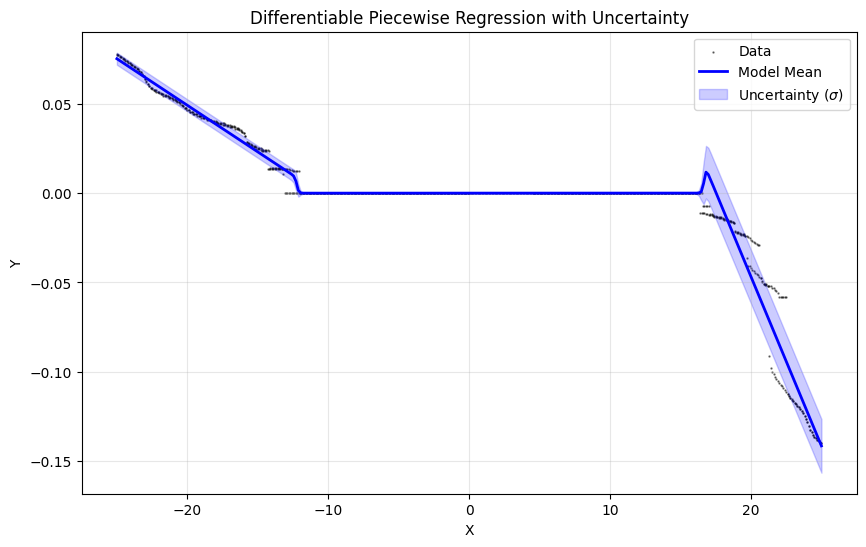

Critical currents: -12.2201, 16.6882
Slopes: [-5.22173602e-03  8.26750696e-07 -1.89774212e-02]


In [18]:
plt.figure(figsize=(10, 6))

# Plot Data
plt.scatter(currents, voltages, color='black', alpha=0.5, label='Data', s = 0.5)

# Plot Mean Prediction
plt.plot(x_test, y_pred, color='blue', linewidth=2, label='Model Mean')

# Plot Uncertainty Bands (1 Sigma)
plt.fill_between(x_test, 
                    y_pred - 1*y_std, 
                    y_pred + 1*y_std, 
                    color='blue', alpha=0.2, label=r'Uncertainty ($\sigma$)')

plt.title("Differentiable Piecewise Regression with Uncertainty")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True, alpha=0.3)

# Highlight the uncertainty spike
plt.annotate('Uncertainty Spike at Discontinuity', xy=(2.0, 6.0), xytext=(4, 9),
                arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

s, i, l, b = model._unpack_params(model.params)
print(f"Critical currents: {b[0]:.4f}, {b[1]:.4f}")
print(f"Slopes: {s}")

In [19]:
model.predict(b)

(array([0.00439147, 0.00809092]), array([0.00493316, 0.01331207]))